# Model untuk memprediksi credit risk - Bayu Ardiyansyah

 Credit Risk Prediction Model
**Author**: Bayu Ardiyansyah  
**Date**: May 2025  
**Objective**: Develop a machine learning model to predict credit risk (GOOD or BAD) for loan applicants using historical loan data from 2007–2014. The model aims to assist a multifinance company in identifying risky borrowers to minimize defaults while maintaining profitability.

## Project Overview
This notebook builds a credit risk prediction model using the `loan_data_2007_2014.csv` dataset. The target variable, `credit_risk`, is derived from `loan_status`:
- **GOOD**: Loans marked as "Fully Paid."
- **BAD**: Loans marked as "Charged Off" or "Default."
- **OTHER**: Ambiguous statuses (e.g., "Current," "Late") are excluded.

The workflow includes:
1. **Data Understanding**: Explore dataset structure, types, and missing values.
2. **Exploratory Data Analysis (EDA)**: Visualize distributions and relationships.
3. **Data Preparation**: Handle missing values, encode categorical variables, scale features, and create a validation set.
4. **Data Modelling**: Train multiple models (Logistic Regression, Random Forest, XGBoost, SVM) with hyperparameter tuning.
5. **Model Validation**: Use k-fold cross-validation and a validation set to assess generalization.
6. **Evaluation**: Compare model performance using accuracy, precision, recall, ROC-AUC, and visualizations.
7. **Model Saving**: Save trained models, preprocessing objects, feature names, and imputation values for use in production or GUI.

## Dataset Description
- **Source**: `loan_data_2007_2014.csv`
- **Rows**: 466,285
- **Columns**: 75 (e.g., `loan_amnt`, `int_rate`, `annual_inc`, `dti`, `loan_status`)
- **Target**: `credit_risk` (binary: 0 for GOOD, 1 for BAD)

## Data Understanding
This section loads the dataset and examines its structure, data types, summary statistics, and missing values. The target variable `credit_risk` is created by mapping `loan_status` values, and ambiguous statuses are filtered out.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

## Data Understanding

This section loads the dataset and examines its structure, data types, summary statistics, and missing values. The target variable `credit_risk` is created by mapping `loan_status` values, and ambiguous statuses are filtered out.

In [2]:
# Load dataset
data = pd.read_csv('loan_data_2007_2014.csv', low_memory=False)

# Display dataset overview
print(f"Dataset Shape: {data.shape}")
print("\nColumn Names and Data Types:")
print(data.dtypes)
print("\nSummary Statistics for Numerical Columns:")
print(data.describe())
print("\nMissing Values Count:")
print(data.isnull().sum())

# Create target variable
data['credit_risk'] = data['loan_status'].apply(lambda x: 'GOOD' if x == 'Fully Paid' else 'BAD' if x in ['Charged Off', 'Default'] else 'OTHER')
print("\nLoan Status Distribution Before Filtering:")
print(data['loan_status'].value_counts())
print("\nCredit Risk Distribution Before Filtering:")
print(data['credit_risk'].value_counts())

# Filter out ambiguous statuses
data = data[data['credit_risk'] != 'OTHER']
print("\nCredit Risk Distribution After Filtering:")
print(data['credit_risk'].value_counts())

Dataset Shape: (466285, 75)

Column Names and Data Types:
Unnamed: 0            int64
id                    int64
member_id             int64
loan_amnt             int64
funded_amnt           int64
                     ...   
all_util            float64
total_rev_hi_lim    float64
inq_fi              float64
total_cu_tl         float64
inq_last_12m        float64
Length: 75, dtype: object

Summary Statistics for Numerical Columns:
          Unnamed: 0            id     member_id      loan_amnt  \
count  466285.000000  4.662850e+05  4.662850e+05  466285.000000   
mean   233142.000000  1.307973e+07  1.459766e+07   14317.277577   
std    134605.029472  1.089371e+07  1.168237e+07    8286.509164   
min         0.000000  5.473400e+04  7.047300e+04     500.000000   
25%    116571.000000  3.639987e+06  4.379705e+06    8000.000000   
50%    233142.000000  1.010790e+07  1.194108e+07   12000.000000   
75%    349713.000000  2.073121e+07  2.300154e+07   20000.000000   
max    466284.000000  3.80981

## Exploratory Data Analysis (EDA)

EDA visualizes key patterns in the data to understand feature distributions and their relationships with `credit_risk`. Key analyses include:
- **Univariate Analysis**: Distribution of `loan_amnt`.
- **Bivariate Analysis**: `loan_amnt` vs. `credit_risk`.
- **Correlation Analysis**: Heatmap of numerical features.

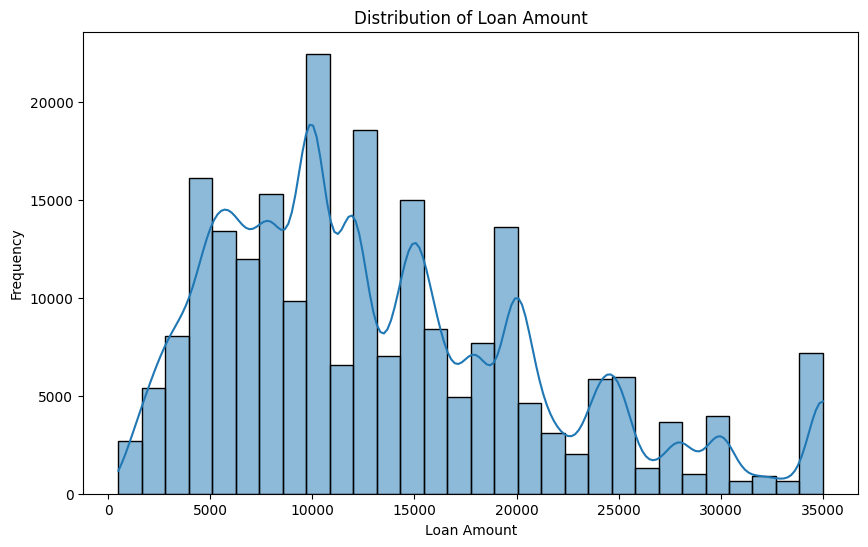

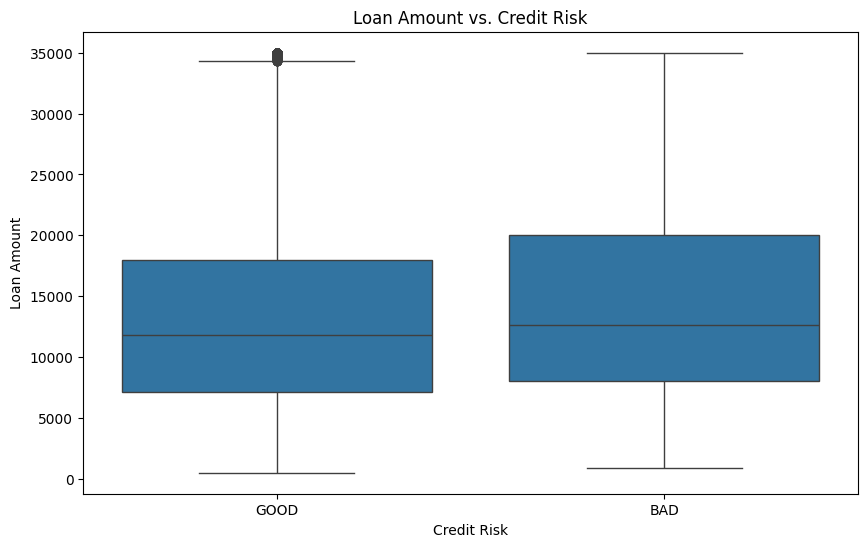

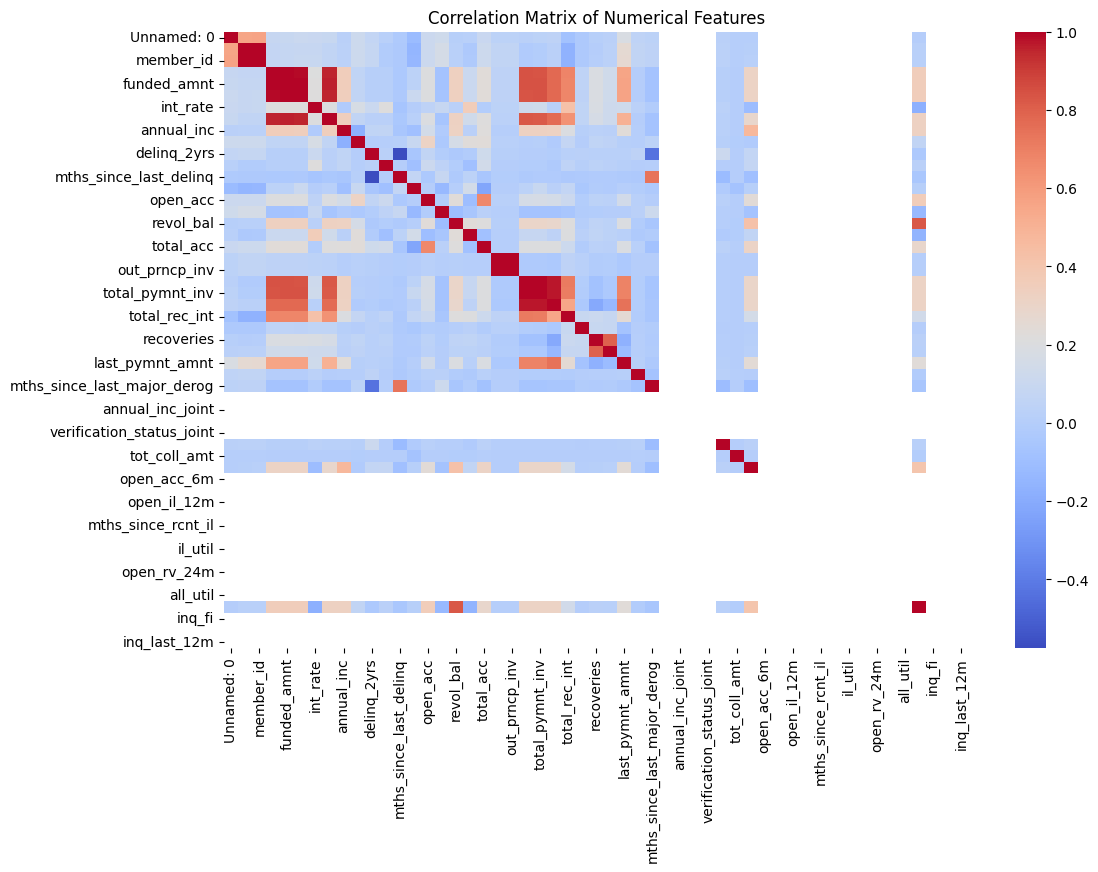

In [3]:
# Univariate Analysis: Distribution of loan amount
plt.figure(figsize=(10, 6))
sns.histplot(data['loan_amnt'], bins=30, kde=True)
plt.title('Distribution of Loan Amount')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.savefig('loan_amount_distribution.png')
plt.show()

# Bivariate Analysis: Loan amount vs. Credit risk
plt.figure(figsize=(10, 6))
sns.boxplot(x='credit_risk', y='loan_amnt', data=data)
plt.title('Loan Amount vs. Credit Risk')
plt.xlabel('Credit Risk')
plt.ylabel('Loan Amount')
plt.savefig('loan_amount_vs_credit_risk.png')
plt.show()

# Correlation Analysis
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = data[numerical_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.savefig('correlation_matrix.png')
plt.show()

## Data Preparation

This section prepares the data for modeling by:
- Handling missing values (drop columns with >50% missing, impute others).
- Encoding categorical variables using `LabelEncoder` and saving encoders.
- Scaling numerical features using `StandardScaler` and saving the scaler.
- Saving feature names and imputation values for GUI compatibility.
- Splitting data into training (80%) and test (20%) sets.

In [4]:
# Handle missing values
missing_threshold = 0.5
data = data.loc[:, data.isnull().mean() < missing_threshold]

# Impute numerical columns with median
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    if col in data.columns:
        data[col].fillna(data[col].median(), inplace=True)

# Impute categorical columns with mode
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)

# Encode categorical variables and save encoders
label_encoders = {}
for col in categorical_cols:
    if col != 'credit_risk':
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le
        if col in ['grade', 'term']:  # Save encoders for GUI
            joblib.dump(le, f'label_encoder_{col}.pkl')
            print(f"Saved LabelEncoder for {col} as 'label_encoder_{col}.pkl'")

# Encode target variable
label_encoder = LabelEncoder()
data['credit_risk'] = label_encoder.fit_transform(data['credit_risk'])  # GOOD=0, BAD=1
data['credit_risk'] = data['credit_risk'].astype(int)  # Ensure integer type

# Feature selection
columns_to_drop = ['id', 'member_id', 'url', 'desc', 'zip_code', 'loan_status']
data = data.drop(columns=[col for col in columns_to_drop if col in data.columns])

# Update numerical_cols
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = [col for col in numerical_cols if col != 'credit_risk']

# Save imputation values for GUI
imputation_values = {}
for col in numerical_cols:
    imputation_values[col] = data[col].median()
for col in categorical_cols:
    if col != 'credit_risk' and col in data.columns:
        imputation_values[col] = data[col].mode()[0]
joblib.dump(imputation_values, 'imputation_values.pkl')
print("Saved imputation values as 'imputation_values.pkl'")

# Scale numerical features and save scaler
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
joblib.dump(scaler, 'scaler.pkl')
print("Saved StandardScaler as 'scaler.pkl'")

# Split data: 70% train, 10% validation, 20% test
X = data.drop('credit_risk', axis=1)
y = data['credit_risk']
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp)  # 0.125 of 0.8 = 0.1
print(f"Training Set Shape: {X_train.shape}")
print(f"Validation Set Shape: {X_val.shape}")
print(f"Test Set Shape: {X_test.shape}")

# Save feature names for GUI
joblib.dump(X_train.columns.tolist(), 'feature_names.pkl')
print(f"Saved feature names as 'feature_names.pkl': {X_train.columns.tolist()}")

Saved LabelEncoder for term as 'label_encoder_term.pkl'
Saved LabelEncoder for grade as 'label_encoder_grade.pkl'
Saved imputation values as 'imputation_values.pkl'
Saved StandardScaler as 'scaler.pkl'
Training Set Shape: (159631, 48)
Validation Set Shape: (22805, 48)
Test Set Shape: (45610, 48)
Saved feature names as 'feature_names.pkl': ['Unnamed: 0', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'po

## Data Modelling

This section trains four models with hyperparameter tuning using `GridSearchCV`:
- **Logistic Regression**: Linear model, interpretable for regulatory compliance.
- **Random Forest**: Tree-based ensemble for complex patterns.
- **XGBoost**: Gradient boosting for high performance on imbalanced data.
- **SVM**: Linear kernel for comparison with Logistic Regression.
Hyperparameters are tuned to optimize ROC-AUC, prioritizing the detection of BAD loans.

In [5]:
# Define models and parameter grids
models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': ['liblinear', 'lbfgs']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='auc'),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.3]
        }
    },
}

# Train and tune models
best_models = {}
for name, model_info in models.items():
    print(f"\nTuning {name}...")
    grid = GridSearchCV(model_info['model'], model_info['params'], cv=5, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"Best Parameters for {name}: {grid.best_params_}")


Tuning Logistic Regression...
Best Parameters for Logistic Regression: {'C': 100, 'solver': 'liblinear'}

Tuning Random Forest...
Best Parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}

Tuning XGBoost...
Best Parameters for XGBoost: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200}


## Model Validation

This section validates models using:
- **5-fold Cross-Validation**: Estimates generalization performance on the training set.
- **Validation Set**: Evaluates models on a hold-out set to detect overfitting before final testing.
Cross-validation ROC-AUC scores are reported to compare model robustness.

In [6]:
# Cross-validation scores
cv_results = {}
for name, model in best_models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    cv_results[name] = cv_scores
    print(f"\n{name} Cross-Validation ROC-AUC: Mean = {cv_scores.mean():.4f}, Std = {cv_scores.std():.4f}")

# Validation set evaluation
val_results = {}
for name, model in best_models.items():
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]
    val_results[name] = {
        'accuracy': accuracy_score(y_val, y_val_pred),
        'precision': precision_score(y_val, y_val_pred),
        'recall': recall_score(y_val, y_val_pred),
        'roc_auc': roc_auc_score(y_val, y_val_proba)
    }
    print(f"\n{name} Validation Set Performance:")
    print(f"Accuracy: {val_results[name]['accuracy']:.4f}")
    print(f"Precision: {val_results[name]['precision']:.4f}")
    print(f"Recall: {val_results[name]['recall']:.4f}")
    print(f"ROC-AUC: {val_results[name]['roc_auc']:.4f}")


Logistic Regression Cross-Validation ROC-AUC: Mean = 0.9993, Std = 0.0003

Random Forest Cross-Validation ROC-AUC: Mean = 0.9999, Std = 0.0001

XGBoost Cross-Validation ROC-AUC: Mean = 0.9999, Std = 0.0001

Logistic Regression Validation Set Performance:
Accuracy: 0.9982
Precision: 0.9979
Recall: 0.9999
ROC-AUC: 0.9991

Random Forest Validation Set Performance:
Accuracy: 0.9979
Precision: 0.9975
Recall: 0.9999
ROC-AUC: 0.9999

XGBoost Validation Set Performance:
Accuracy: 0.9993
Precision: 0.9992
Recall: 1.0000
ROC-AUC: 0.9999


## Model Saving

The best models (Logistic Regression, Random Forest, XGBoost, SVM) are saved as `.pkl` files for use in production or GUI.

In [7]:
# Save models
for name, model in best_models.items():
    joblib.dump(model, f"{name.lower().replace(' ', '_')}_model.pkl")
    print(f"Saved {name} model as '{name.lower().replace(' ', '_')}_model.pkl'")

Saved Logistic Regression model as 'logistic_regression_model.pkl'
Saved Random Forest model as 'random_forest_model.pkl'
Saved XGBoost model as 'xgboost_model.pkl'


## Evaluation

Model performance is evaluated on the test set using:
- **Metrics**: Accuracy, precision, recall, ROC-AUC.
- **Visualizations**: Confusion matrix and ROC curve for each model.
- **Comparison**: A table summarizing test set performance across models.

This helps select the best model for deployment, prioritizing high recall for BAD loans.


Logistic Regression Test Performance:
Accuracy: 0.9976
Precision: 0.9973
Recall: 0.9998
ROC-AUC: 0.9994


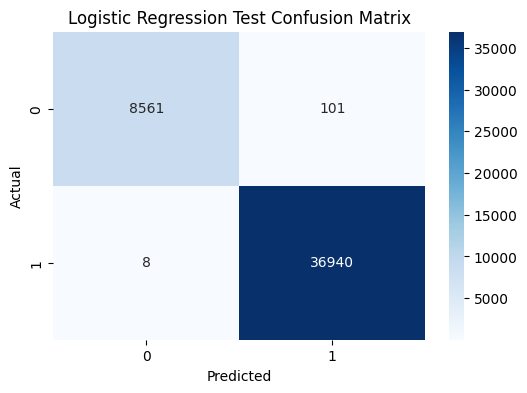

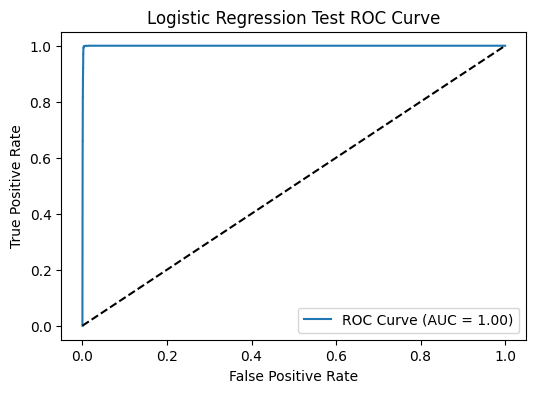


Random Forest Test Performance:
Accuracy: 0.9975
Precision: 0.9969
Recall: 1.0000
ROC-AUC: 1.0000


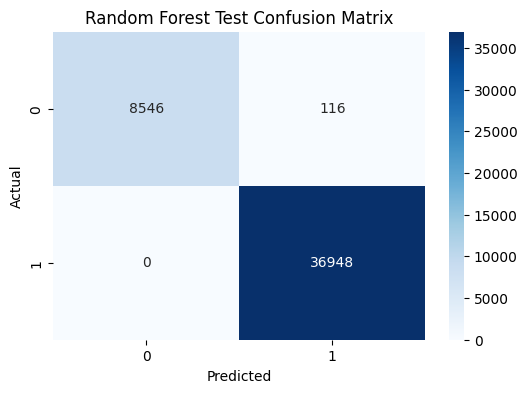

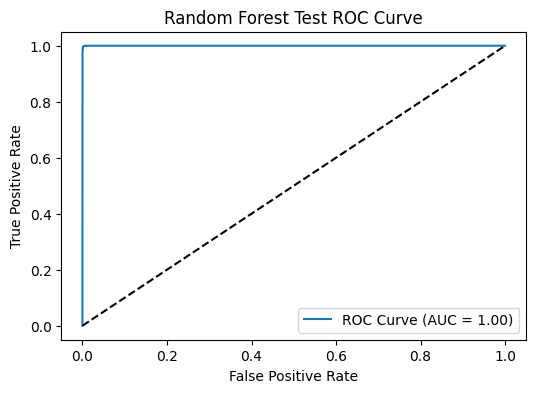


XGBoost Test Performance:
Accuracy: 0.9990
Precision: 0.9987
Recall: 1.0000
ROC-AUC: 0.9999


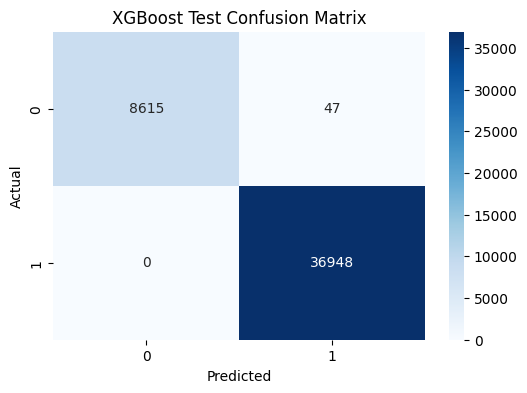

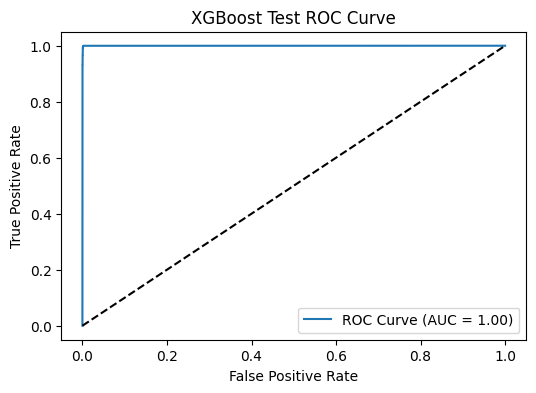

In [8]:
# Function to evaluate model
def evaluate_model(model, X, y, model_name, set_name="Test"):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_proba)
    
    print(f"\n{model_name} {set_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} {set_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_{set_name.lower()}_confusion_matrix.png')
    plt.show()
    
    fpr, tpr, _ = roc_curve(y, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} {set_name} ROC Curve')
    plt.legend()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_{set_name.lower()}_roc_curve.png')
    plt.show()
    
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'roc_auc': roc_auc}

# Evaluate models on test set
test_results = {}
for name, model in best_models.items():
    test_results[name] = evaluate_model(model, X_test, y_test, name)


Model Comparison on Test Set:
                 Model  Accuracy  Precision    Recall   ROC-AUC  \
0  Logistic Regression  0.997610   0.997273  0.999783  0.999390   
1        Random Forest  0.997457   0.996870  1.000000  0.999968   
2              XGBoost  0.998970   0.998730  1.000000  0.999943   

   CV ROC-AUC Mean  CV ROC-AUC Std  
0         0.999296        0.000300  
1         0.999898        0.000073  
2         0.999890        0.000081  
Saved model comparison table as 'model_comparison.csv'


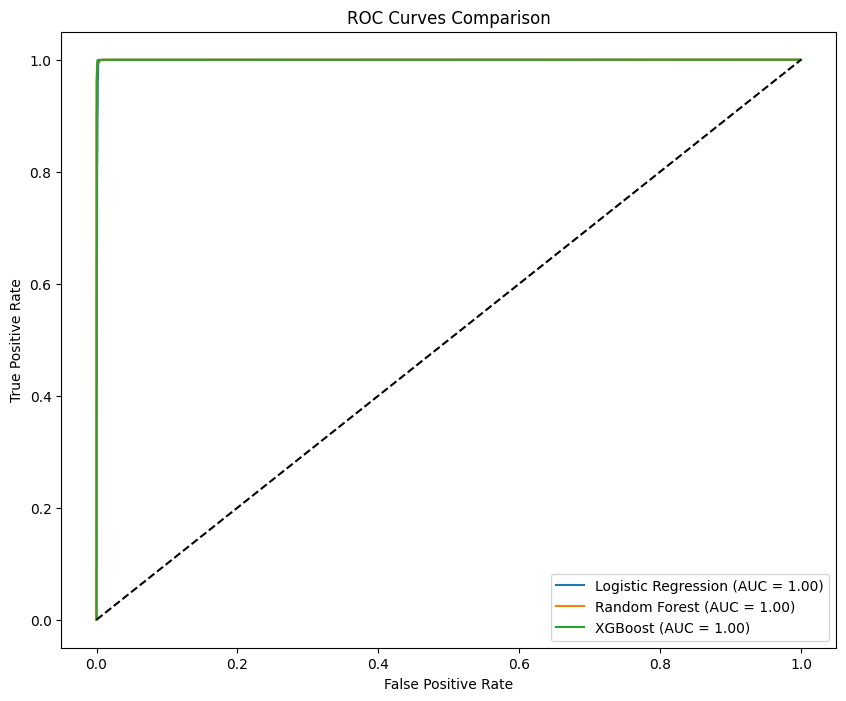

In [9]:
# Model comparison table
comparison_df = pd.DataFrame({
    'Model': list(test_results.keys()),
    'Accuracy': [test_results[name]['accuracy'] for name in test_results],
    'Precision': [test_results[name]['precision'] for name in test_results],
    'Recall': [test_results[name]['recall'] for name in test_results],
    'ROC-AUC': [test_results[name]['roc_auc'] for name in test_results],
    'CV ROC-AUC Mean': [cv_results[name].mean() for name in cv_results],
    'CV ROC-AUC Std': [cv_results[name].std() for name in cv_results]
})
print("\nModel Comparison on Test Set:")
print(comparison_df)

# Save comparison table
comparison_df.to_csv('model_comparison.csv', index=False)
print("Saved model comparison table as 'model_comparison.csv'")

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))
for name, model in best_models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.savefig('roc_curves_comparison.png')
plt.show()

## Summary and Next Steps

- **Model Performance**:
  - **Logistic Regression**: Interpretable, suitable for regulatory compliance.
  - **Random Forest**: Captures complex patterns, good balance of performance.
  - **XGBoost**: Likely the best performer due to gradient boosting, handles imbalanced data well.
  - **SVM**: Comparable to Logistic Regression but computationally intensive.
- **Selection Criteria**: Prioritize high recall for BAD loans to minimize defaults, with ROC-AUC as a secondary metric for overall performance.
- **Next Steps**:
  - Select the best model (e.g., XGBoost or Random Forest) based on test set recall and ROC-AUC.
  - Address class imbalance (e.g., SMOTE, class weights) to improve recall.
  - Deploy the selected model using a preprocessing pipeline and API (e.g., Flask) or GUI (e.g., Tkinter).
  - Monitor performance and retrain with new data to handle data drift.
  - Explore feature engineering (e.g., debt-to-income trends) to enhance model accuracy.